# Combined Weather, Generation and Capacity data for Machine Learning

# 1.0 Checking the Functions and Dataframe Rerturned are Complete

In [218]:
# Environments
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pytz
from datetime import datetime
from pvlive_api import PVLive
import time
from datetime import datetime, timedelta, timezone
import requests_cache
from retry_requests import retry
import openmeteo_requests

In [219]:
# Initiating PVLive API as per GIT repo instructions: https://github.com/SheffieldSolar/PV_Live-API
pvl = PVLive(
    retries=3, # Optionally set the number of retries when intermittent issues are encountered
    proxies=None, # Optionally pass a dict of proxies to use when making requests
    ssl_verify=True, # Optionally disable SSL certificate verification (not advised!)
    domain_url="api.pvlive.uk", # Optionally switch between the prod and FOF APIs
)

In [220]:
# Set GSP and timeframes to call functions
start = datetime(2025, 1, 1, 0, 0, tzinfo=pytz.UTC)
end = datetime(2025, 12, 31, 23, 30, tzinfo=pytz.UTC)
gsp_id = 124  # select GSP ID to extract data for - later we will ue table of names for this

In [221]:
def load_mwp(region="gsp", include_history=True):
    """
    Load and return the MWp deployment dataframe as mwp_df via pvl.deployment.
    """
    mwp_df = pvl.deployment(region=region, include_history=include_history)
    return mwp_df

def load_gsp(gsp_path="../data/gsp_info.csv"):
    """
    Load and return the GSP info dataframe as gsp_df from CSV,
    filtered to only GSPs known to PVLive (pvl.gsp_ids).
    """
    pvl = PVLive()
    valid_ids = set(pvl.gsp_ids)

    gsp_df = pd.read_csv(gsp_path)

    if 'gsp_id' in gsp_df.columns:
        # coerce non-numeric to NaN, drop those rows, cast to int, then filter by PVLive ids
        gsp_df['gsp_id_num'] = pd.to_numeric(gsp_df['gsp_id'], errors='coerce')
        gsp_df = gsp_df[gsp_df['gsp_id_num'].notna()].copy()
        gsp_df['gsp_id_num'] = gsp_df['gsp_id_num'].astype(int)
        gsp_df = gsp_df[gsp_df['gsp_id_num'].isin(valid_ids)].drop(columns=['gsp_id_num']).reset_index(drop=True)

    return gsp_df

def merge_gsp_location(mwp_df, gsp_df, gsp_col_mwp='GSPs', gsp_col_gsp='gsp_name'):
    """
    Return a copy of mwp_df with columns gsp_lat, gsp_lon, region_name merged from gsp_df.
    Matching is done case-insensitive and with whitespace stripped.
    Remove the 'unkown' rows from the mwp_df - presumably misspelling of unknown.
    Drop any rows with missing values.
    
    """
    # Make copies to avoid mutating inputs
    mwp = mwp_df.copy()
    gsp = gsp_df.copy()

    # Normalize join keys by aligning to string, stripping and putting in upper case
    mwp['_gsp_key'] = mwp[gsp_col_mwp].astype(str).str.strip().str.upper()
    gsp['_gsp_key'] = gsp[gsp_col_gsp].astype(str).str.strip().str.upper()

    # Select only the columns we want to bring across (plus join key)
    to_merge = gsp[['_gsp_key', 'gsp_id', 'gsp_lat', 'gsp_lon', 'region_name', 'pes_id']].drop_duplicates('_gsp_key')    
    merged = mwp.merge(to_merge, on='_gsp_key', how='left') # Left merge so all mwp rows are kept
    merged = merged.dropna(how='any')   # drop all rows where ther are NaN values - return only the 299 intersection GSPs
    merged = merged[merged[gsp_col_mwp] != 'unkown']  # return the df where not equal to unkown
    merged = merged.drop(columns=['_gsp_key'])  # Drop linking key

    return merged
    
def gsp_locations(merged_df, gsp_col='GSPs'):
    """
    Return a DataFrame with one row per unique GSP containing
    gsp_col, gsp_lat, gsp_lon, region_name, pes_id, and a combined
    'GSP_region' column formatted "GSPs | region_name".
    """
    gsp_locations_list = (
        merged_df
        .drop_duplicates(subset=[gsp_col])[[gsp_col, 'gsp_id', 'gsp_lat', 'gsp_lon', 'region_name', 'pes_id']]
        .reset_index(drop=True)
    )
    gsp_locations_list['GSP_region'] = gsp_locations_list[gsp_col].astype(str) + ' | ' + gsp_locations_list['region_name'].astype(str)
    return gsp_locations_list

def wide_cumul_capacity(merged_df, time_col='install_month', gsp_col='GSPs', value_col='cumul_capacity_mwp'):
    """
    Return a DataFrame with:
    - one column for the time (time_col) monthly intervals
    - one column per GSP (column name = GSP identifier)
    - cells = value_col (cumulative capacity MWP)
    """
    import pandas as pd
    df = merged_df.copy()
    try:
        df[time_col] = pd.to_datetime(df[time_col])
    except Exception:
        pass
    wide = df.pivot_table(index=time_col, columns=gsp_col, values=value_col, aggfunc='first')
    wide = wide.reset_index()  # make time a regular column
    return wide

def download_generation_for_single_gsp(start, end, gsp_id, gsp_locations_list, include_national=False, extra_fields=""):
    """
    Return a DataFrame with:
    - generation data for selected period for one GSP
    - one column for the time (time_col) HH intervals
    - other columns for GSP identifiers
    """
    valid_ids = gsp_locations_list['gsp_id'].dropna().astype(int).unique()  # Get the valid gsp_ids from gsp_locations_list
    if gsp_id not in valid_ids:  # Check if the provided gsp_id is valid
        return f"Please select a GSP ID which appears in the GSP capacity list."

    # Fetch data for the specific GSP ID using between function from PVLive API Class
    generation_df = pvl.between(
        start=start,
        end=end,
        entity_type="gsp",
        entity_id=int(gsp_id),
        dataframe=True,
        extra_fields=extra_fields
    )

    # Interpolate up to 24 consecutive NaN values in the generation output - 12 in either direction  
    if generation_df is not None and not generation_df.empty:
        generation_df['datetime_gmt'] = pd.to_datetime(generation_df['datetime_gmt'])
        generation_df = generation_df.sort_values(['gsp_id', 'datetime_gmt']).set_index('datetime_gmt')
        generation_df['generation_mw'] = (
            generation_df.groupby('gsp_id')['generation_mw']
            .apply(lambda s: s.interpolate(method='time', limit=12, limit_direction='both'))
            .reset_index(level=0, drop=True)
        )
        generation_df = generation_df.reset_index()
        
    # Merge additional columns from gsp_locations_list
    gsp_info = gsp_locations_list[gsp_locations_list['gsp_id'] == gsp_id]
    if not gsp_info.empty:
        # Merge on gsp_id to include other columns like gsp_lat, gsp_lon, etc.
        generation_df = generation_df.merge(gsp_info, on='gsp_id', how='left')
        
    return generation_df

def get_capacity_data_single_gsp(gsp_id, merged_df):
    """
    Return a DataFrame containing capacity data for the specified GSP ID,
    along with month and year columns based on the install_month
    
    """
    # Filter the DataFrame for the specified GSP ID and add time-series columns for mathing with generation df
    capacity_data = merged_df[merged_df['gsp_id'] == gsp_id].copy()
    capacity_data = capacity_data[['install_month', 'cumul_capacity_mwp', 'GSPs', 'gsp_lat', 'gsp_lon', 'region_name', 'pes_id']]   # Keep relevant columns
    capacity_data['install_month'] = pd.to_datetime(capacity_data['install_month'])    # Convert install_month to datetime
    capacity_data['month'] = capacity_data['install_month'].dt.month     # Create 'month' and 'year' columns
    capacity_data['year'] = capacity_data['install_month'].dt.year
    capacity_data['day'] = capacity_data['install_month'].dt.day
    capacity_data['hour'] = capacity_data['install_month'].dt.hour
    return capacity_data.reset_index(drop=True)

def add_capacity_to_generation(generation_df, capacity_data, tz='UTC', gen_fill_method='interpolate'):
    """
    Merge cumulative capacity into generation_df, then reindex to a full 30-minute UTC grid
    and interpolate missing generation_mw and capacity_mwp values. Returns DataFrame indexed by datetime_gmt (tz-aware).
    
    Parameters:
    - generation_df: DataFrame with 'datetime_gmt' and 'generation_mw'
    - capacity_data: DataFrame with ['month', 'year', 'cumul_capacity_mwp']
    - tz: timezone for indexing (default 'UTC')
    - gen_fill_method: 'interpolate' (default) or 'zero' to fill generation gaps
    """
    # Ensure datetime and timezone
    generation_df = generation_df.copy()
    generation_df['datetime_gmt'] = pd.to_datetime(generation_df['datetime_gmt'])
    if generation_df['datetime_gmt'].dt.tz is None:
        generation_df['datetime_gmt'] = generation_df['datetime_gmt'].dt.tz_localize(tz)
    else:
        generation_df['datetime_gmt'] = generation_df['datetime_gmt'].dt.tz_convert(tz)

    # Add time components
    generation_df['month'] = generation_df['datetime_gmt'].dt.month
    generation_df['year'] = generation_df['datetime_gmt'].dt.year
    generation_df['day'] = generation_df['datetime_gmt'].dt.day
    generation_df['hour'] = generation_df['datetime_gmt'].dt.hour

    # Merge capacity (by month/year) and forward-fill capacity
    merged_df = generation_df.merge(
        capacity_data[['month', 'year', 'cumul_capacity_mwp']],
        on=['month', 'year'],
        how='left'
    ).rename(columns={'cumul_capacity_mwp': 'capacity_mwp'})
    merged_df['capacity_mwp'] = merged_df['capacity_mwp'].ffill()

    # Set datetime index and select relevant columns, including ffill on specific fields
    merged_df = merged_df.set_index('datetime_gmt').sort_index()

    # Build full 30-minute index from min to max
    full_idx = pd.date_range(merged_df.index.min(), merged_df.index.max(), freq='30min', tz=tz)

    # Reindex to full grid
    merged_df = merged_df.reindex(full_idx)

    # Fill remaining NaNs for generation_mw
    if 'generation_mw' in merged_df.columns:
        if gen_fill_method == 'interpolate':
            merged_df['generation_mw'] = merged_df['generation_mw'].interpolate(limit_direction='both')
        else:
            merged_df['generation_mw'] = merged_df['generation_mw'].fillna(0)
    
    # Fill remaining NaNs for capacity_mw
    if 'capacity_mwp' in merged_df.columns:
        if gen_fill_method == 'interpolate':
            merged_df['capacity_mwp'] = merged_df['capacity_mwp'].interpolate(limit_direction='both')
        else:
            merged_df['capacity_mwp'] = merged_df['capacity_mwp'].fillna(0)
        
    # Forward fill for newly made specific non-numeric columns
    ffill_columns = ['gsp_id', 'GSPs', 'gsp_lat', 'gsp_lon', 'region_name', 'pes_id', 'GSP_region']
    for col in ffill_columns:
        if col in merged_df.columns:
            merged_df[col] = merged_df[col].ffill()

    # Recompute time component columns from index for any newly created rows
    merged_df['month'] = merged_df.index.month
    merged_df['year'] = merged_df.index.year
    merged_df['day'] = merged_df.index.day
    merged_df['hour'] = merged_df.index.hour

    # Reset index name to 'datetime_gmt'
    merged_df.index.name = 'datetime_gmt'

    return merged_df.reset_index()

def fetch_weather_for_generation_df(gen_df,
                                    cache_path=".cache",
                                    cache_expire=3600,
                                    retries=5,
                                    backoff_factor=0.2):
    """
    Extract lat/lon and date range from generation_and_capacity_single_gsp-like
    DataFrame (expects 'gsp_lat', 'gsp_lon', 'datetime_gmt'), call Open-Meteo via
    openmeteo_requests and return hourly weather DataFrame indexed by UTC datetime
    with added columns: year, month, day, hour.
    """
    # Extract lat/lon from first non-null row
    row = gen_df[['gsp_lat', 'gsp_lon']].dropna().iloc[0]
    latitude, longitude = float(row['gsp_lat']), float(row['gsp_lon'])

    # Derive start/end dates (YYYY-MM-DD)
    start_date = gen_df['datetime_gmt'].min().normalize().strftime('%Y-%m-%d')
    end_date = gen_df['datetime_gmt'].max().normalize().strftime('%Y-%m-%d')

    # Setup client with cache + retry
    cache_session = requests_cache.CachedSession(cache_path, expire_after=cache_expire)
    retry_session = retry(cache_session, retries=retries, backoff_factor=backoff_factor)
    client = openmeteo_requests.Client(session=retry_session)
    if not hasattr(client, "_close_session"):
        client._close_session = False  # avoid destructor AttributeError

    hourly_vars = [
        "shortwave_radiation", "direct_radiation", "diffuse_radiation",
        "direct_normal_irradiance", "global_tilted_irradiance",
        "shortwave_radiation_instant", "direct_radiation_instant", "diffuse_radiation_instant",
        "direct_normal_irradiance_instant", "global_tilted_irradiance_instant",
    ]

    url = "https://historical-forecast-api.open-meteo.com/v1/forecast"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": hourly_vars,
    }

    responses = client.weather_api(url, params=params)
    if not responses:
        return pd.DataFrame()

    response = responses[0]
    hourly = response.Hourly()
    hourly_arrays = [hourly.Variables(i).ValuesAsNumpy() for i in range(len(hourly_vars))]

    start_ts = pd.to_datetime(hourly.Time(), unit="s", utc=True)
    end_ts = pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True)
    interval_seconds = int(hourly.Interval())
    dates = pd.date_range(
        start=start_ts,
        end=end_ts,
        freq=pd.Timedelta(seconds=interval_seconds),
        inclusive="left"
    )

    data = {"date": dates}
    for name, arr in zip(hourly_vars, hourly_arrays):
        data[name] = arr[: len(dates)]

    df = pd.DataFrame(data).set_index("date")

    # Add year, month, day, hour columns from the index
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['hour'] = df.index.hour

    return df

def merge_generation_with_weather(generation_df, weather_df):
    """
    Merge generation_and_capacity_single_gsp dataframe with weather_df.
    Only brings generation_mw and capacity_mwp from generation_df.
    - generation_df: must contain ['year','month','day','hour','generation_mw','capacity_mwp']
      (two half-hour rows per hour; this function averages per hour).
    - weather_df: indexed by UTC datetime and must contain columns ['year','month','day','hour']
    Returns: DataFrame with weather_df index and merged averaged columns:
             generation_mw, capacity_mwp (aligned to weather hourly rows).
    """
    # Select only required columns
    cols = ['year', 'month', 'day', 'hour', 'generation_mw', 'capacity_mwp']
    gen = generation_and_capacity_single_gsp[cols].copy()
    grouped = gen.groupby(['year', 'month', 'day', 'hour'], as_index=False)[['generation_mw', 'capacity_mwp']].mean() # Aggregate to hourly by mean
    weather = weather_df.copy().reset_index()  # bring datetime index to column named 'date'
    merged = weather.merge(grouped, on=['year', 'month', 'day', 'hour'], how='left') # Merge with weather_df on year,month,day,hour
    
    # Failsafe itnterpolate remaining NaN values in generation_mw and capacity_mwp
    if 'generation_mw' in merged.columns:
        merged['generation_mw'] = merged['generation_mw'].interpolate(limit_direction='both')

    if 'capacity_mwp' in merged.columns:
        merged['capacity_mwp'] = merged['capacity_mwp'].interpolate(limit_direction='both')
   
    # restore datetime index
    merged = merged.set_index('date')

    return merged


In [222]:
# Call functions and create variables with dataframes for use in the app
mwp_df = load_mwp() # loading the capacity df
gsp_df = load_gsp() # loading the gsp locations df
merged_df = merge_gsp_location(mwp_df, gsp_df) # merge capacity growth and locations
gsp_locations_list = gsp_locations(merged_df) # merge capacity and locations without capacity growth over time
generation_df = download_generation_for_single_gsp(start, end, gsp_id, gsp_locations_list) # generation df for selected gsp
capacity_growth_all_gsps = wide_cumul_capacity(merged_df) # wide capacity growth df for all time and all gsps
capacity_data_single_gsp = get_capacity_data_single_gsp(gsp_id, merged_df) # add month and year to capacity single gsp
generation_and_capacity_single_gsp = add_capacity_to_generation(generation_df, capacity_data_single_gsp) # merged capacity and generation same time-series single gsp
weather_df = fetch_weather_for_generation_df(generation_and_capacity_single_gsp) # weather df for the selected gsp and time period
gen_weather_merged_df = merge_generation_with_weather(generation_and_capacity_single_gsp, weather_df)
gen_weather_merged_df

,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,global_tilted_irradiance,shortwave_radiation_instant,direct_radiation_instant,diffuse_radiation_instant,direct_normal_irradiance_instant,global_tilted_irradiance_instant,year,month,day,hour,generation_mw,capacity_mwp
date,,,,,,,,,,,,,,,,
2025-01-01 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2025,1,1,0,0.0,7.358246
2025-01-01 01:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2025,1,1,1,0.0,7.358246
2025-01-01 02:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2025,1,1,2,0.0,7.358246
2025-01-01 03:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2025,1,1,3,0.0,7.358246
2025-01-01 04:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2025,1,1,4,0.0,7.358246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-31 19:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2025,12,31,19,0.0,8.076596
2025-12-31 20:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2025,12,31,20,0.0,8.076596
2025-12-31 21:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2025,12,31,21,0.0,8.076596


In [223]:
# Check for NaNs in gen_weather_merged_df
print("Any NaNs anywhere in gen_weather_merged_df:", gen_weather_merged_df.isna().any().any())

# Count NaNs per column
print("\nNaN count per column in gen_weather_merged_df:")
print(gen_weather_merged_df.isna().sum())

# Count of rows with any NaN
n_rows_with_nan = gen_weather_merged_df.isna().any(axis=1).sum()
print(f"\nNumber of rows with any NaN: {n_rows_with_nan} out of {len(gen_weather_merged_df)}")

# Show all rows that contain any NaN (up to 20 for a quick check)
nan_rows = gen_weather_merged_df[gen_weather_merged_df.isna().any(axis=1)]


Any NaNs anywhere in gen_weather_merged_df: False

NaN count per column in gen_weather_merged_df:
shortwave_radiation                 0
direct_radiation                    0
diffuse_radiation                   0
direct_normal_irradiance            0
global_tilted_irradiance            0
shortwave_radiation_instant         0
direct_radiation_instant            0
diffuse_radiation_instant           0
direct_normal_irradiance_instant    0
global_tilted_irradiance_instant    0
year                                0
month                               0
day                                 0
hour                                0
generation_mw                       0
capacity_mwp                        0
dtype: int64

Number of rows with any NaN: 0 out of 8760


#### There is complete data for 2025 given there are 8760 hours in the year with zero NaN values!

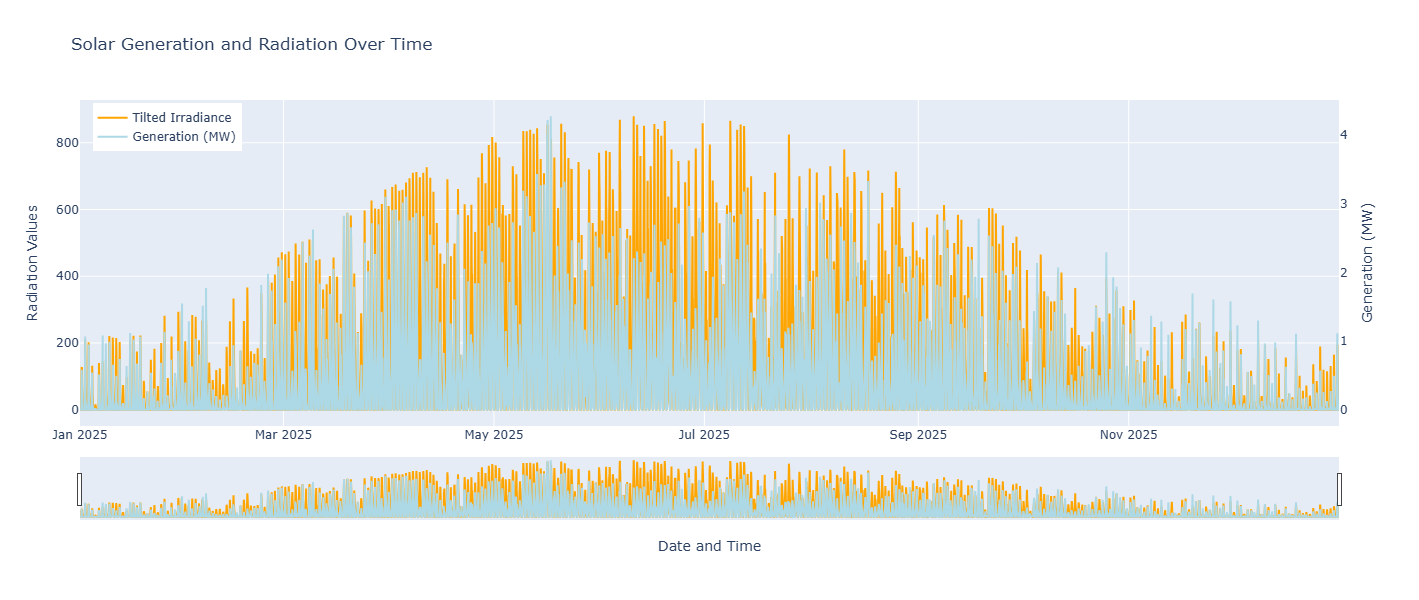

In [224]:
import plotly.graph_objects as go
import pandas as pd

# Work on a copy to avoid mutating the original
df = gen_weather_merged_df.copy()

# Create a datetime column from the index (no extra tz handling)
df['datetime_gmt'] = pd.to_datetime(df.index)

# Create a Plotly figure
fig = go.Figure()

# Add line trace for shortwave radiation
fig.add_trace(go.Scatter(
    x=df['datetime_gmt'],
    y=df['global_tilted_irradiance_instant'],
    mode='lines',
    name='Tilted Irradiance',
    line=dict(color='orange')
))

# Add line trace for generation, setting secondary y-axis
fig.add_trace(go.Scatter(
    x=df['datetime_gmt'],
    y=df['generation_mw'],
    mode='lines',
    name='Generation (MW)',
    line=dict(color='lightblue'),
    yaxis='y2'
))

# Update layout to add a second y-axis
fig.update_layout(
    title='Solar Generation and Radiation Over Time',
    xaxis_title='Date and Time',
    yaxis_title='Radiation Values',
    yaxis2=dict(
        title='Generation (MW)',
        overlaying='y',
        side='right',
        showgrid=False
    ),
    xaxis=dict(rangeslider=dict(visible=True)),
    legend=dict(x=0.01, y=0.99),
    height=600
)

# Show the plot
fig.show()


# 2.0 Machine Learning

##### 2.1 Split the data into train and test sets 80/20

In [225]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(
                                    gen_weather_merged_df.drop(['generation_mw'],axis=1),
                                    gen_weather_merged_df['generation_mw'],
                                    test_size=0.2,
                                    random_state=101
                                    )

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (7008, 15) (7008,) 
* Test set: (1752, 15) (1752,)


##### 2.2 Random Forest Pipeline:

In [226]:
from sklearn.pipeline import Pipeline

### Feat Scaling
from sklearn.preprocessing import StandardScaler

### Feat Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithms 
from sklearn.ensemble import RandomForestRegressor


def pipeline_random_forest_reg():
  pipeline = Pipeline([
      ( "feat_scaling",StandardScaler() ),
      ( "feat_selection",SelectFromModel(RandomForestRegressor(random_state=42)) ),
      ( "model", RandomForestRegressor(random_state=42)),

  ])

  return pipeline

pipeline_random_forest_reg()

,steps,"[('feat_scaling', ...), ('feat_selection', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,estimator,RandomForestR...ndom_state=42)
,threshold,None
,prefit,False
,norm_order,1


Fit the model

In [227]:
pipeline = pipeline_random_forest_reg()
pipeline.fit(X_train, y_train)

,steps,"[('feat_scaling', ...), ('feat_selection', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,estimator,RandomForestR...ndom_state=42)
,threshold,None
,prefit,False
,norm_order,1


Since it is a tree-based model, we can assess in the model the importance of the features with .features_importance_

In [228]:
def feature_importance_tree_based_models(model, columns):
  """
  Gets the model and the columns used to train the model
  - We use the model.feature_importances_ and columns to make a
  DataFrame that shows the importance of each feature
  - Next, we print the feature name and its relative importance order,
  followed by a barplot indicating the importance

  """

  # create DataFrame to display feature importance
  df_feature_importance = (pd.DataFrame(data={
      'Features': columns,
      'Importance': model.feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

  best_features = df_feature_importance['Features'].to_list()

  # Most important features statement and plot
  print(f"* These are the {len(best_features)} most important features in descending order. "
        f"The model was trained on them: \n{df_feature_importance['Features'].to_list()}")

  df_feature_importance.plot(kind='bar',x='Features',y='Importance')
  plt.show()


* These are the 3 most important features in descending order. The model was trained on them: 
['shortwave_radiation_instant', 'global_tilted_irradiance_instant', 'diffuse_radiation_instant']


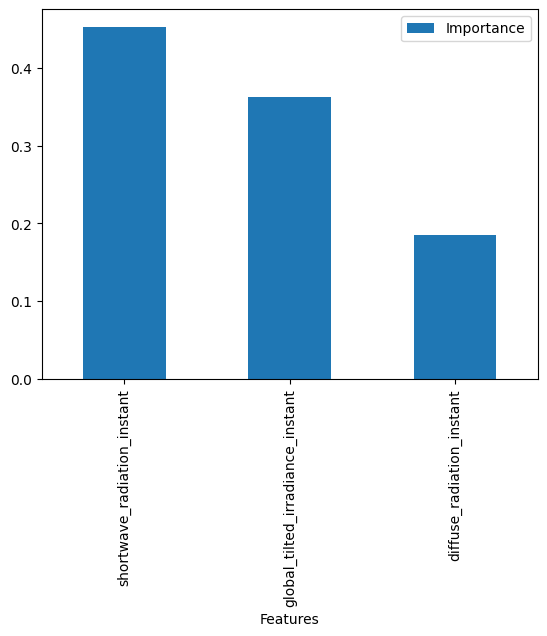

In [229]:
feature_importance_tree_based_models(model = pipeline['model'],
                                     columns =  X_train.columns[pipeline['feat_selection'].get_support()])

##### Use Regression Scoring Functions from Code Institute:

In [230]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
import numpy as np

def regression_performance(X_train, y_train, X_test, y_test,pipeline):
	print("Model Evaluation \n")
	print("* Train Set")
	regression_evaluation(X_train,y_train,pipeline)
	print("* Test Set")
	regression_evaluation(X_test,y_test,pipeline)

def regression_evaluation(X,y,pipeline):
  """
  # Gets features and target (either from train or test set) and pipeline
  - it predicts using the pipeline and the features
  - calculates performance metrics comparing the prediction to the target
  """
  prediction = pipeline.predict(X)
  print('R2 Score:', round(r2_score(y, prediction),3))
  print('Mean Absolute Error:', round(mean_absolute_error(y, prediction),3))  
  print('Mean Squared Error:', round(mean_squared_error(y, prediction),3))  
  print('Root Mean Squared Error:', round(np.sqrt(mean_squared_error(y, prediction)),3))
  print("\n")
  

def regression_evaluation_plots(X_train, y_train, X_test, y_test,pipeline, alpha_scatter=0.5):
  pred_train = pipeline.predict(X_train)
  pred_test = pipeline.predict(X_test)


  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
  sns.scatterplot(x=y_train , y=pred_train, alpha=alpha_scatter, ax=axes[0])
  sns.lineplot(x=y_train , y=y_train, color='red', ax=axes[0])
  axes[0].set_xlabel("Actual")
  axes[0].set_ylabel("Predictions")
  axes[0].set_title("Train Set")

  sns.scatterplot(x=y_test , y=pred_test, alpha=alpha_scatter, ax=axes[1])
  sns.lineplot(x=y_test , y=y_test, color='red', ax=axes[1])
  axes[1].set_xlabel("Actual")
  axes[1].set_ylabel("Predictions")
  axes[1].set_title("Test Set")
  plt.show()


Model Evaluation 

* Train Set
R2 Score: 0.963
Mean Absolute Error: 0.062
Mean Squared Error: 0.017
Root Mean Squared Error: 0.13


* Test Set
R2 Score: 0.745
Mean Absolute Error: 0.168
Mean Squared Error: 0.118
Root Mean Squared Error: 0.343




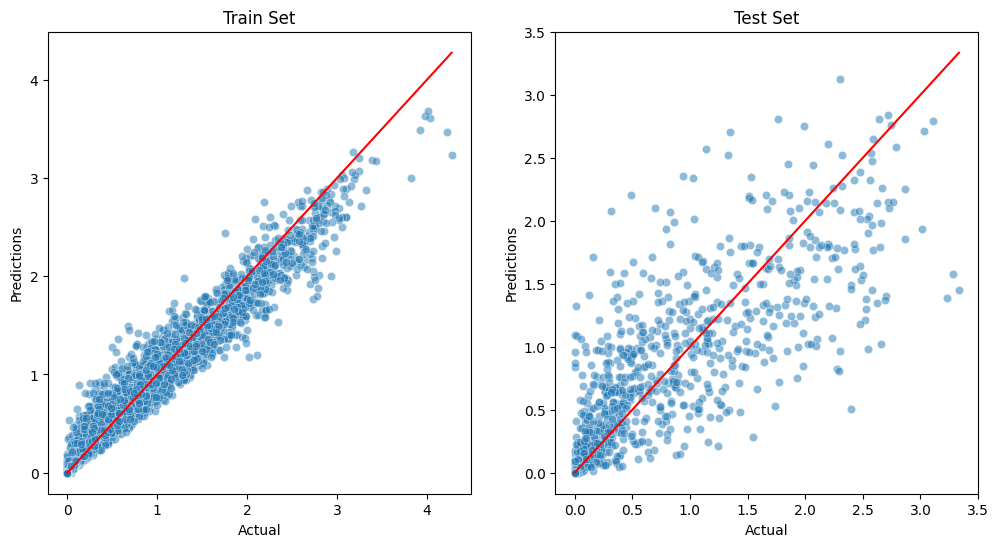

In [231]:
regression_performance(X_train, y_train, X_test, y_test, pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, 
                            pipeline, alpha_scatter=0.5)

##### RF Model Evaluation:

* The R2 score on the Test set is 0.963
* The R2 score on the Train set is 0.745
* We can see the train set distribution is much closer than the test set distribution
* Meaning the model has significantly overfitted, so we will tune the model's hyperparameters

##### RF Hyperparameter Tuning

Model Evaluation 

* Train Set
R2 Score: 0.807
Mean Absolute Error: 0.145
Mean Squared Error: 0.088
Root Mean Squared Error: 0.297


* Test Set
R2 Score: 0.779
Mean Absolute Error: 0.158
Mean Squared Error: 0.102
Root Mean Squared Error: 0.319




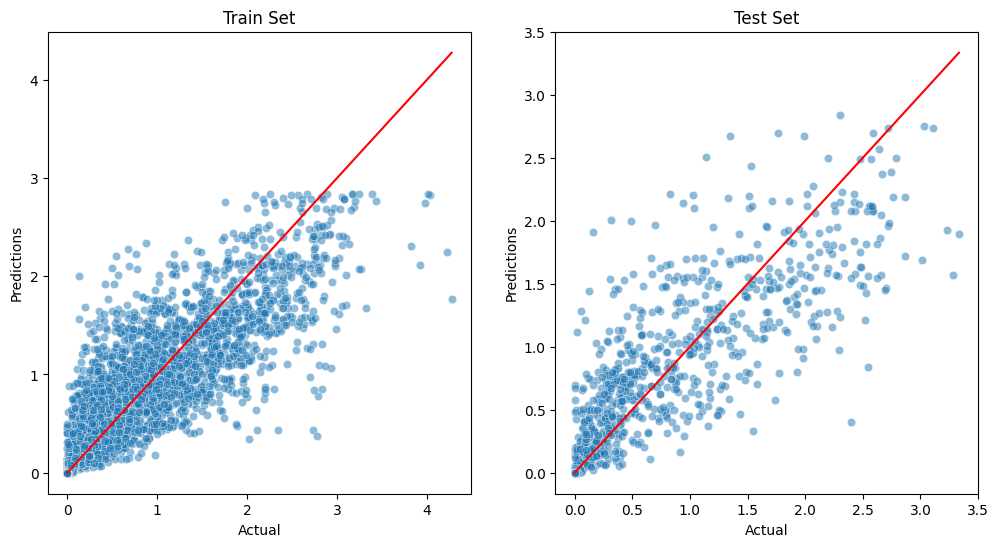

In [232]:
def pipeline_random_forest_reg():
    pipeline = Pipeline([
        ("feat_scaling", StandardScaler()),
        ("feat_selection", SelectFromModel(RandomForestRegressor(random_state=42))),
        ("model", RandomForestRegressor(
            random_state=42,
            n_estimators=50,
            max_depth=30,
            min_samples_split=30,
            min_samples_leaf=20
        )),
    ])
    return pipeline

pipeline_random_forest_reg()

pipeline = pipeline_random_forest_reg()
pipeline.fit(X_train, y_train)

regression_performance(X_train, y_train, X_test, y_test, pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, 
                            pipeline, alpha_scatter=0.5)

This model is not as badly overfitted but the score isn't as high as we'd like, let's try XGBoost:

##### 2.3 XGBoost modelling

In [234]:
from sklearn.pipeline import Pipeline

### Feat Scaling
from sklearn.preprocessing import StandardScaler

### Feat Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithms 
from xgboost import XGBRegressor

def pipeline_xgboost_reg():
  pipeline = Pipeline([
      ( "feat_selection",SelectFromModel(XGBRegressor(random_state=42)) ),
      ( "model", XGBRegressor(random_state=42)),

    ])
  return pipeline
    
pipeline = pipeline_xgboost_reg()
pipeline.fit(X_train, y_train)

,steps,"[('feat_selection', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,estimator,"XGBRegressor(...ree=None, ...)"
,threshold,None
,prefit,False
,norm_order,1
,max_features,None
,importance_getter,'auto'
,objective,'reg:squarederror'


* These are the 3 most important features in descending order. The model was trained on them: 
['global_tilted_irradiance_instant', 'shortwave_radiation_instant', 'direct_radiation_instant']


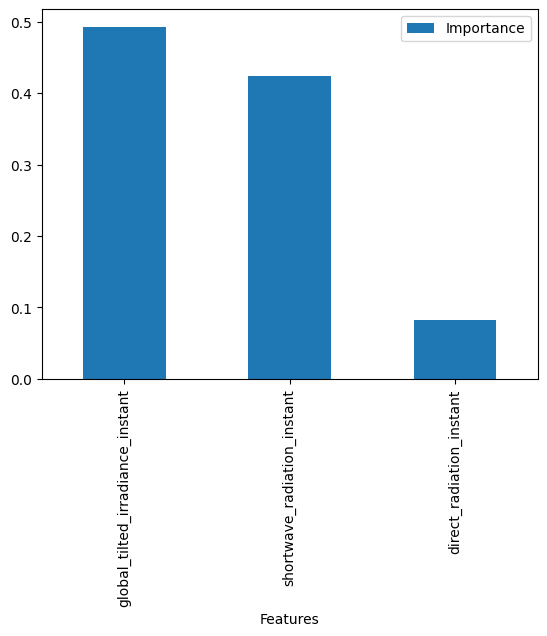

In [235]:
feature_importance_tree_based_models(model = pipeline['model'],
                                     columns =  X_train.columns[pipeline['feat_selection'].get_support()]
                                     )

The same two features are the most important: 

* terrestrial_radiation_instant
* global_tilted_irradiance_instant

with the third from the Random Forest (shortwave_radiation_instant) dropping off the list 

Model Evaluation 

* Train Set
R2 Score: 0.919
Mean Absolute Error: 0.094
Mean Squared Error: 0.037
Root Mean Squared Error: 0.192


* Test Set
R2 Score: 0.733
Mean Absolute Error: 0.173
Mean Squared Error: 0.123
Root Mean Squared Error: 0.351




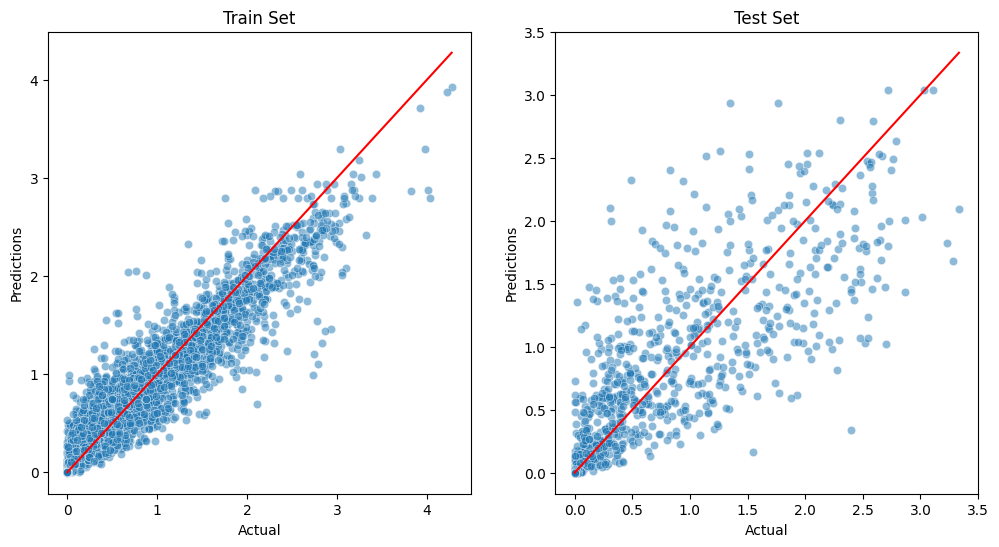

In [236]:
regression_performance(X_train, y_train, X_test, y_test, pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, 
                            pipeline, alpha_scatter=0.5)

There is still significant overfitting in the model with a slightly lower scoring overall:

* We will test some hyperparameters with XGBoost

Model Evaluation 

* Train Set
R2 Score: 0.797
Mean Absolute Error: 0.165
Mean Squared Error: 0.093
Root Mean Squared Error: 0.304


* Test Set
R2 Score: 0.775
Mean Absolute Error: 0.176
Mean Squared Error: 0.104
Root Mean Squared Error: 0.323




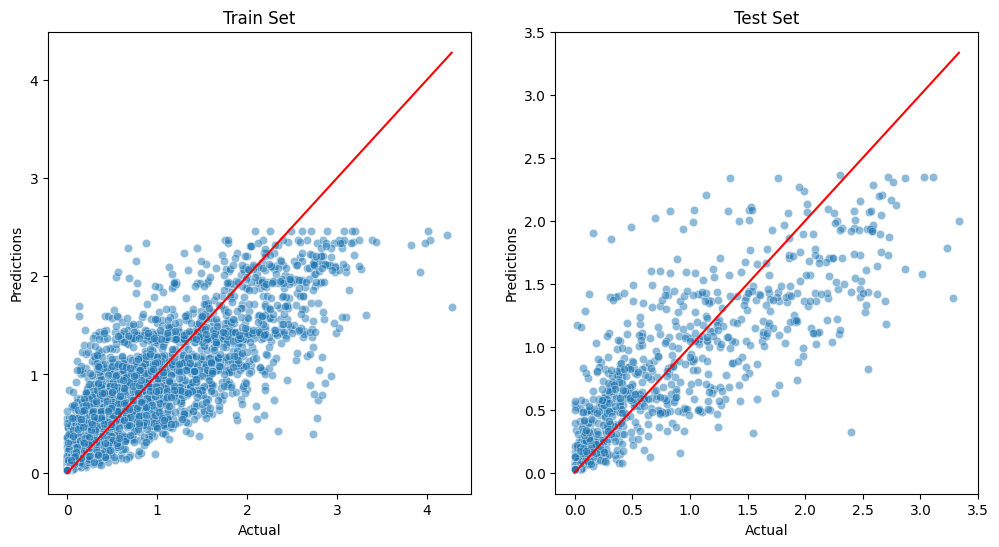

In [237]:
def pipeline_xgboost_reg():
    pipeline = Pipeline([
        ("feat_selection", SelectFromModel(XGBRegressor(random_state=42, n_estimators=50, n_jobs=-1, verbosity=0))),
        ("model", XGBRegressor(
            random_state=42,
            n_estimators=50,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=1.0,
            reg_lambda=1.0,
            n_jobs=-1,
            verbosity=0
        )),
    ])
    return pipeline

pipeline_xgboost_reg()

pipeline = pipeline_xgboost_reg()
pipeline.fit(X_train, y_train)

regression_performance(X_train, y_train, X_test, y_test, pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, 
                            pipeline, alpha_scatter=0.5)

### This is the closest fitting model which we will take forward to the streamlit app

##### 2.4 Extratrees modelling

In [238]:
from sklearn.pipeline import Pipeline

### Feat Scaling
from sklearn.preprocessing import StandardScaler

### Feat Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithms 
from sklearn.ensemble import ExtraTreesRegressor

def pipeline_extratrees_reg():
  pipeline = Pipeline([
      ( "feat_selection",SelectFromModel(ExtraTreesRegressor(random_state=42)) ),
      ( "model", ExtraTreesRegressor(random_state=42)),

    ])
  return pipeline


In [239]:
pipeline = pipeline_extratrees_reg()
pipeline.fit(X_train, y_train)

,steps,"[('feat_selection', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,estimator,ExtraTreesReg...ndom_state=42)
,threshold,None
,prefit,False
,norm_order,1
,max_features,None
,importance_getter,'auto'
,n_estimators,100


Model Evaluation 

* Train Set
R2 Score: 1.0
Mean Absolute Error: 0.0
Mean Squared Error: 0.0
Root Mean Squared Error: 0.001


* Test Set
R2 Score: 0.721
Mean Absolute Error: 0.172
Mean Squared Error: 0.129
Root Mean Squared Error: 0.359




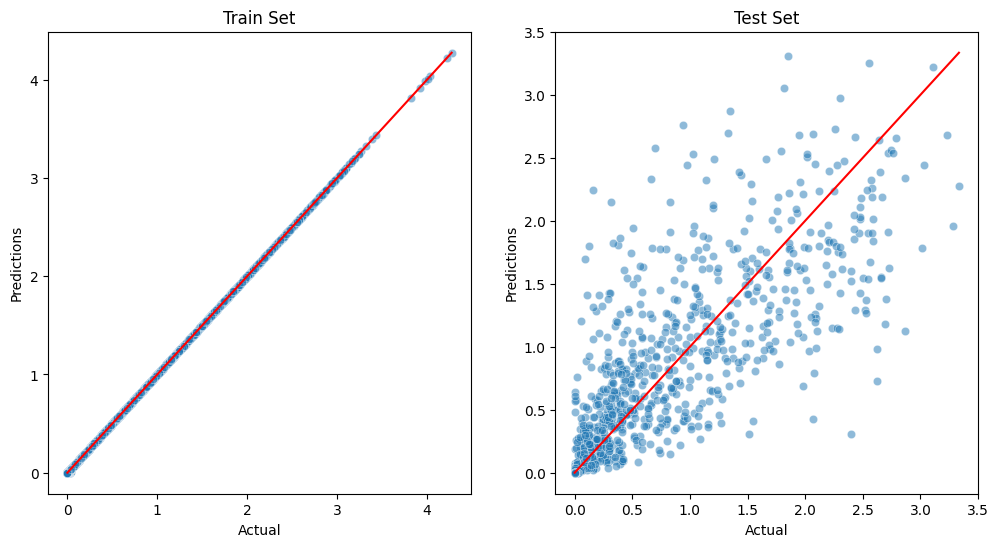

In [240]:
regression_performance(X_train, y_train, X_test, y_test, pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, 
                            pipeline, alpha_scatter=0.5)

This is very overfitted, let's tune the model:

Model Evaluation 

* Train Set
R2 Score: 0.764
Mean Absolute Error: 0.165
Mean Squared Error: 0.108
Root Mean Squared Error: 0.328


* Test Set
R2 Score: 0.769
Mean Absolute Error: 0.167
Mean Squared Error: 0.107
Root Mean Squared Error: 0.327




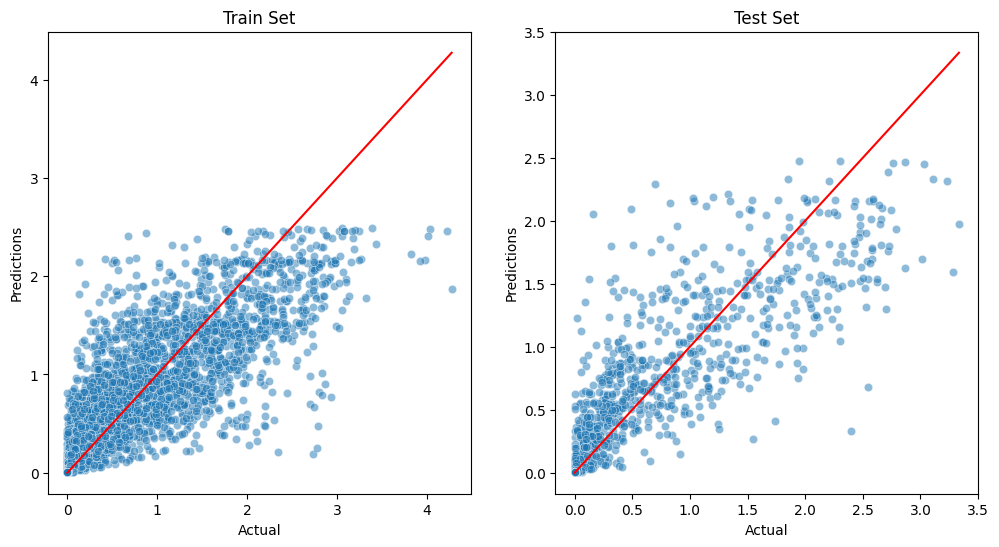

In [241]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesRegressor

def pipeline_extratrees_reg():
    pipeline = Pipeline([
        ("feat_selection", SelectFromModel(ExtraTreesRegressor(random_state=42))),
        ("model", ExtraTreesRegressor(
            random_state=42,
            n_estimators=100,          # Default, can adjust to more or less as needed
            max_depth=4,              # Control maximum depth of trees to reduce variance
            min_samples_split=10,      # Minimum number of samples required to split an internal node
            min_samples_leaf=8,        # Minimum number of samples allowed in a leaf node
            max_features='sqrt',       # Maximum features taken at each split (sqrt for regression)
            bootstrap=False             # Using the whole dataset, change to True if using subsets
        )),
    ])
    return pipeline

pipeline = pipeline_extratrees_reg()
pipeline.fit(X_train, y_train)

# Perform performance evaluation
regression_performance(X_train, y_train, X_test, y_test, pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5)


##### 2.5 Gradient Boosting Modelling

Model Evaluation 

* Train Set
R2 Score: 0.773
Mean Absolute Error: 0.162
Mean Squared Error: 0.104
Root Mean Squared Error: 0.322


* Test Set
R2 Score: 0.771
Mean Absolute Error: 0.166
Mean Squared Error: 0.106
Root Mean Squared Error: 0.325




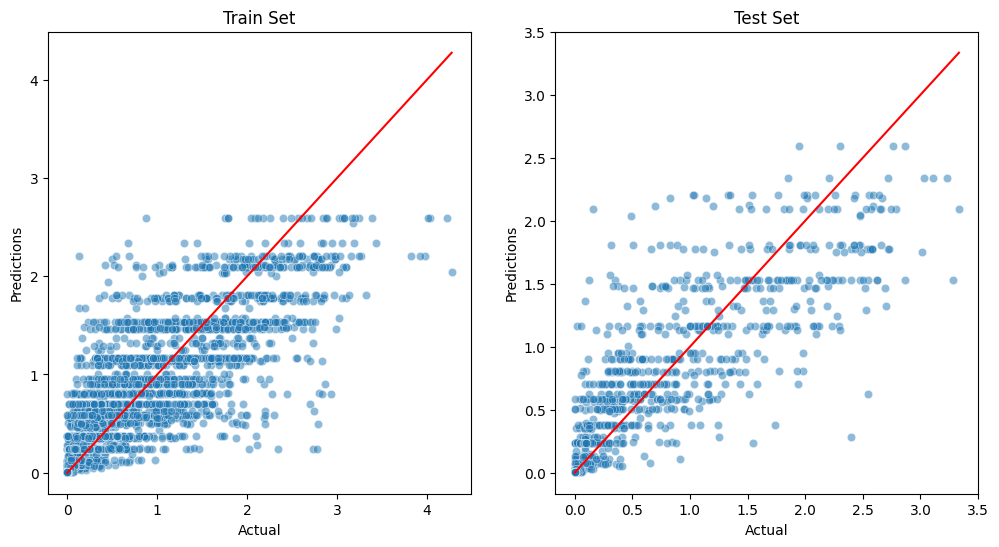

In [242]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingRegressor

def pipeline_gradient_boosting_reg():
    pipeline = Pipeline([
        ("feat_selection", SelectFromModel(GradientBoostingRegressor(random_state=42))),
        ("model", GradientBoostingRegressor(
            random_state=42,
            n_estimators=30,         # Number of boosting stages to be run
            learning_rate=0.15,       # Step size shrinkage to prevent overfitting
            max_depth=2,              # Maximum depth of the individual trees
            min_samples_split=50,     # Minimum number of samples required to split an internal node
            min_samples_leaf=5,       # Minimum number of samples allowed in a leaf node
            subsample=0.9,            # Fraction of samples to be used for fitting the individual trees
            max_features='sqrt',      # Number of features to consider when looking for the best split
        )),
    ])
    return pipeline

# Create the pipeline and fit to the training data
pipeline = pipeline_gradient_boosting_reg()
pipeline.fit(X_train, y_train)

# Perform performance evaluation
regression_performance(X_train, y_train, X_test, y_test, pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5)
